In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg
/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg
/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg
/kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg
/kaggle/input/gan-getting-started/monet_jpg/d05cab011d.jpg
/kaggle/input/gan-getting-started/monet_jpg/4e05523825.jpg
/kaggle/input/gan-getting-started/monet_jpg/c68c52e8fc.jpg
/kaggle/input/gan-getting-started/monet_jpg/40d7d18ad3.jpg
/kaggle/input/gan-getting-started/monet_jpg/f96a8de9f3.jpg
/kaggle/input/gan-getting-started/monet_jpg/79224da51f.jpg
/kaggle/input/gan-getting-started/monet_jpg/23832dead5.jpg
/kaggle/input/gan-getting-started/monet_jpg/85580214be.jpg
/kaggle/input/gan-getting-started/monet_jpg/47a0548067.jpg
/kaggle/input/gan-getting-started/monet_jpg/fb93438ff9.jpg
/kaggle/input/gan-getting-started/monet_jpg/89d970411d.jpg
/kaggle/input/gan-getting-started/monet_jpg/7960adbd50.j

# Libraries

In [2]:
import os
import tensorflow as tf
import random
import shutil
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from tqdm.auto import tqdm
from tqdm.keras import TqdmCallback
import zipfile
import re

from tensorflow.keras import layers, Model


2025-07-23 02:56:29.926474: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753239390.181294      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753239390.255857      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Configuration

In [3]:
BATCH_SIZE = 1
LAMBDA = 10.0
EPOCHS = 10
GEN_BATCH = 500
TOTAL_IMGS = 7000

# Data Paths

## Data Folders

In [4]:
INPUT_DIR    = "/kaggle/input/gan-getting-started"

MONET_JPG    = os.path.join(INPUT_DIR, "monet_jpg")
PHOTO_JPG    = os.path.join(INPUT_DIR, "photo_jpg")

OUTPUT_DIR = "/kaggle/working/output"
IMG_SNAPSHOT_DIR = os.path.join(OUTPUT_DIR, "snapshots")
CKPT_DIR = os.path.join(OUTPUT_DIR, "checkpoints")
IMG_DIR = os.path.join(OUTPUT_DIR, "images")

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(IMG_SNAPSHOT_DIR, exist_ok=True)
os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(IMG_DIR, exist_ok=True)

SUBMISSION_ZIP = "/kaggle/working/images.zip"

In [5]:
print("JPG folders:")
print("  Monet:", len(os.listdir(MONET_JPG)),   "files")
print("  Photo:", len(os.listdir(PHOTO_JPG)),   "files")

print("Output directory:", OUTPUT_DIR)
print("Contents:", os.listdir(OUTPUT_DIR))

JPG folders:
  Monet: 300 files
  Photo: 7038 files
Output directory: /kaggle/working/output
Contents: ['snapshots', 'checkpoints', 'images']


## Data Files

In [6]:
# JPEG files
monet_files   = sorted(glob(os.path.join(MONET_JPG,   "*.jpg")))
photo_files   = sorted(glob(os.path.join(PHOTO_JPG,   "*.jpg")))

In [7]:
print(f"Monet JPG files:      {len(monet_files)}")
print(f"Photo JPG files:      {len(photo_files)}")

Monet JPG files:      300
Photo JPG files:      7038


# Data Pipeline

## JPG Pipeline

In [8]:
def decode_jpg(image_path, image_size=(256,256), augment=False):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    if augment:
        image = tf.image.random_flip_left_right(image)
    # normalize to [-1,1]
    return (tf.cast(image, tf.float32) / 127.5) - 1.0

In [9]:
def make_jpg_dataset(file_paths, batch_size=1, shuffle_buffer=1000, image_size=(256,256), augment=False):
    """
    Creates a tf.data.Dataset from JPEG file paths.
    """
    ds = tf.data.Dataset.from_tensor_slices(file_paths)
    ds = ds.map(lambda p: decode_jpg(p, image_size, augment),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache()
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


In [10]:
monet_ds  = make_jpg_dataset(monet_files,  batch_size=BATCH_SIZE, augment=True)
photo_ds  = make_jpg_dataset(photo_files,  batch_size=BATCH_SIZE, augment=True)

2025-07-23 02:56:47.672043: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [11]:
print("JPG pipeline batch shape:   ", next(iter(monet_ds)).shape)

JPG pipeline batch shape:    (1, 256, 256, 3)


# Visualize Samples

## Preview Function

In [12]:
def show_random_jpgs(file_list, num_images=9, cols=3, img_size=(256,256)):
    """
    Display a random selection of JPEGs in a grid.
    """
    # Safety check
    num_images = min(num_images, len(file_list))
    
    # Pick random subset
    chosen = random.sample(file_list, num_images)
    rows = int(np.ceil(num_images / cols))
    
    plt.figure(figsize=(cols * 4, rows * 4))
    for idx, fp in enumerate(chosen):
        img = Image.open(fp).resize(img_size)
        ax = plt.subplot(rows, cols, idx+1)
        plt.imshow(img)
        plt.title(f"{os.path.basename(fp)}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

## Monet Paintings

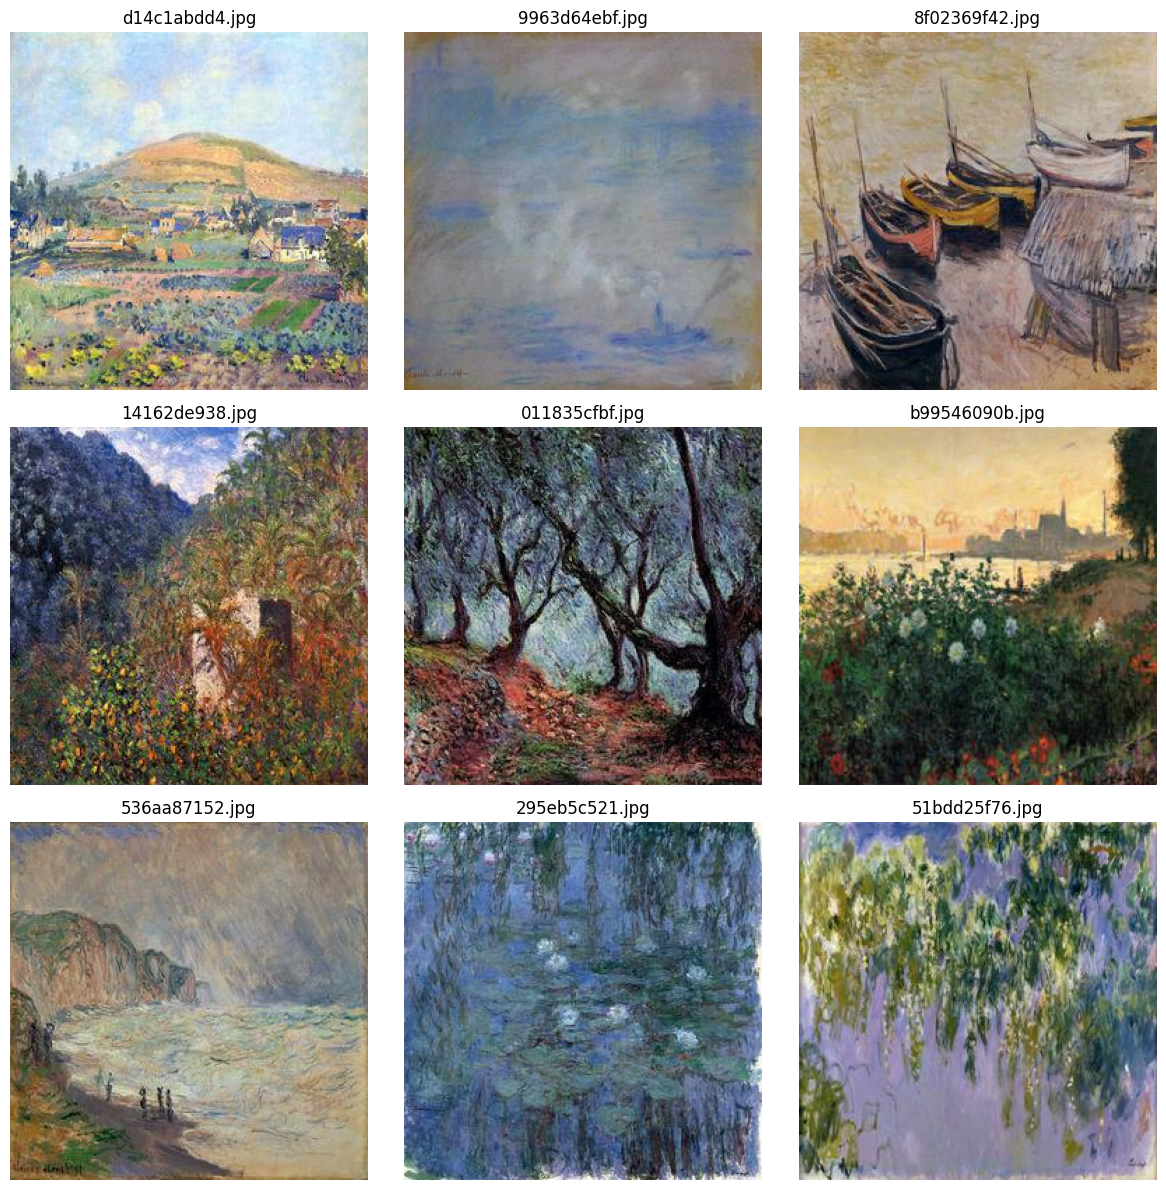

In [13]:
show_random_jpgs(monet_files, num_images=9, cols=3)

## Photographs

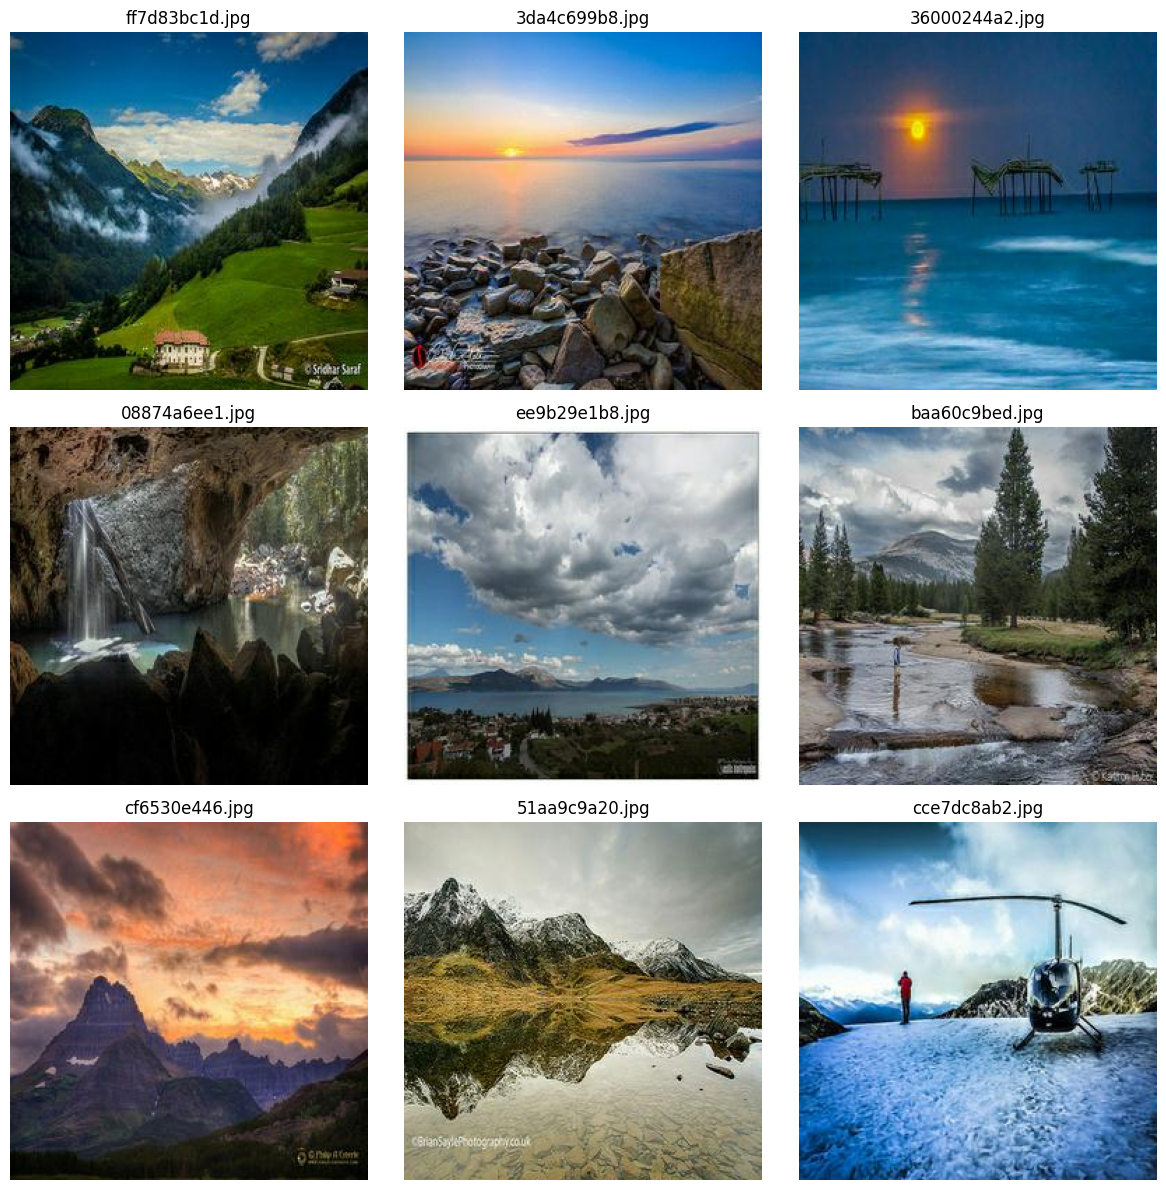

In [14]:
show_random_jpgs(photo_files, num_images=9, cols=3)

# Exploratory Data Analysis

## Stat Function

In [15]:
def compute_stats(file_list, n=200):
    means, stds = [], []
    sample = random.sample(file_list, min(len(file_list), n))
    for path in sample:
        img = Image.open(path).resize((256,256))
        arr = np.array(img).astype(np.float32)/255.0
        means.append(arr.mean(axis=(0,1)))
        stds.append(arr.std(axis=(0,1)))
    return np.stack(means), np.stack(stds)

In [16]:
monet_means, monet_stds = compute_stats(monet_files)
photo_means, photo_stds = compute_stats(photo_files)

## Mean Brightness Per-Image

### Monet Paintings

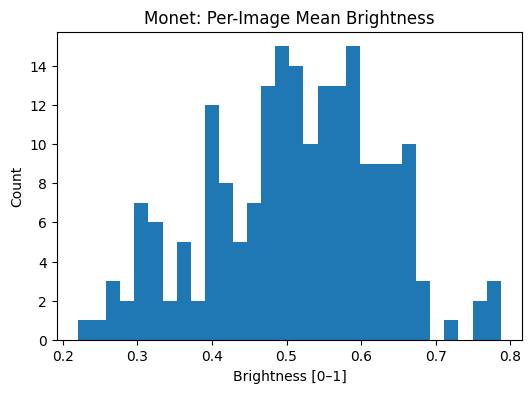

In [17]:
plt.figure(figsize=(6,4))
plt.hist(monet_means.mean(axis=1), bins=30)
plt.title("Monet: Per-Image Mean Brightness")
plt.xlabel("Brightness [0–1]")
plt.ylabel("Count")
plt.show()

### Photographs

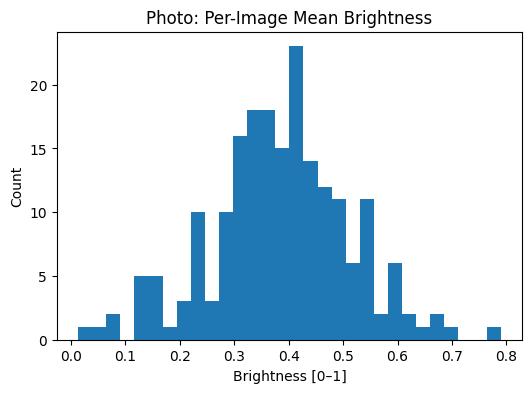

In [18]:
plt.figure(figsize=(6,4))
plt.hist(photo_means.mean(axis=1), bins=30)
plt.title("Photo: Per-Image Mean Brightness")
plt.xlabel("Brightness [0–1]")
plt.ylabel("Count")
plt.show()

## Mean Brightness Per-Channel

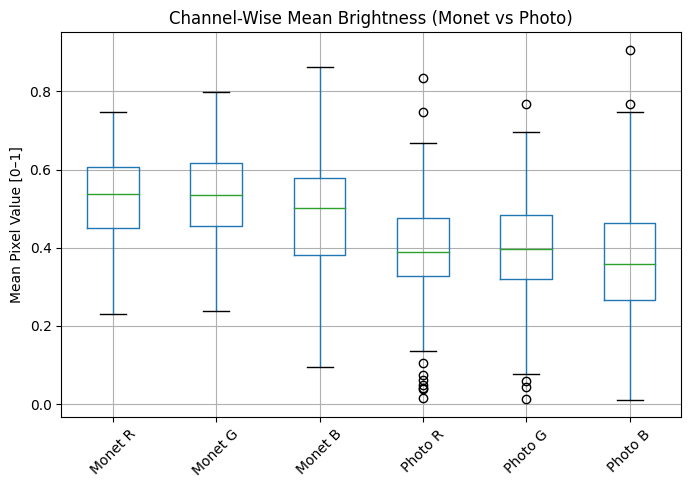

In [19]:
df = pd.DataFrame({
    'Monet R': monet_means[:,0],
    'Monet G': monet_means[:,1],
    'Monet B': monet_means[:,2],
    'Photo R': photo_means[:,0],
    'Photo G': photo_means[:,1],
    'Photo B': photo_means[:,2],
})

plt.figure(figsize=(8,5))
df.boxplot()
plt.title("Channel-Wise Mean Brightness (Monet vs Photo)")
plt.ylabel("Mean Pixel Value [0–1]")
plt.xticks(rotation=45)
plt.show()

## Color Distribution

In [20]:
def plot_color_histogram(file_list, title, bins=50):
    # Accumulate all pixel values per channel (might sample to save RAM)
    sample = random.sample(file_list, min(len(file_list), 300))
    all_pixels = np.concatenate([
        np.array(Image.open(fp).resize((256,256))).reshape(-1,3) 
        for fp in sample
    ], axis=0) / 255.0  # [0–1]
    
    plt.figure(figsize=(6,4))
    for i, col in enumerate(('R','G','B')):
        plt.hist(all_pixels[:,i], bins=bins, alpha=0.5, label=col)
    plt.title(title)
    plt.xlabel("Pixel value [0–1]")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

### Monet Paintings

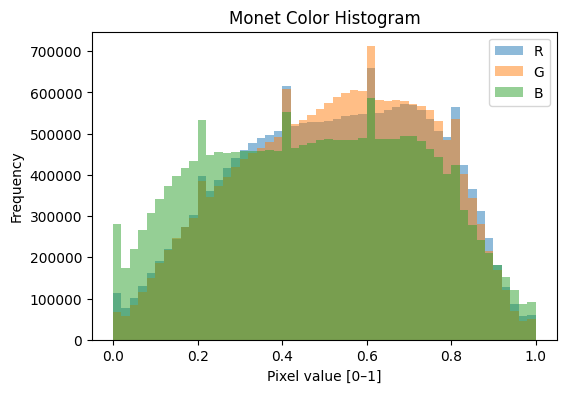

In [21]:
plot_color_histogram(monet_files, "Monet Color Histogram")

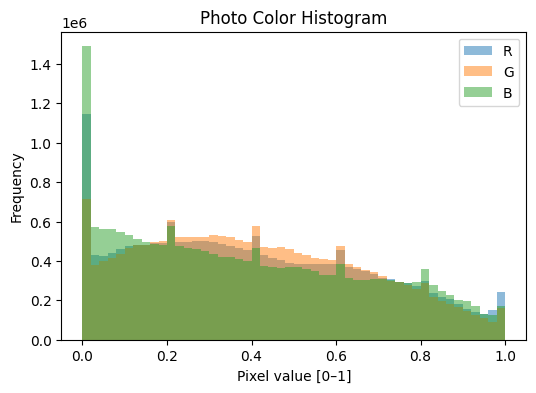

In [22]:
plot_color_histogram(photo_files, "Photo Color Histogram")


## Edge Density / Texture Analysis

In [23]:
def compute_edge_densities(file_list, num=200):
    densities = []
    sample = random.sample(file_list, min(len(file_list), num))
    for fp in sample:
        # 1) Load & normalize image
        img = tf.io.decode_jpeg(tf.io.read_file(fp), channels=3)
        img = tf.image.resize(img, [256,256]) / 255.0
        
        # 2) Grayscale → shape [256,256,1]
        gray = tf.image.rgb_to_grayscale(img)
        
        # 3) Add batch dim → shape [1,256,256,1]
        gray_batched = tf.expand_dims(gray, axis=0)
        
        # 4) Sobel edges → shape [1,256,256,1,2]
        edges = tf.image.sobel_edges(gray_batched)
        
        # 5) Magnitude along last axis → shape [1,256,256,1]
        mag = tf.sqrt(tf.reduce_sum(tf.square(edges), axis=-1))
        
        # 6) Remove batch & channel dims → [256,256]
        mag = tf.squeeze(mag, axis=[0,3])
        
        # 7) Mean edge magnitude
        densities.append(tf.reduce_mean(mag).numpy())
        
    return np.array(densities)

In [24]:
monet_edges = compute_edge_densities(monet_files)
photo_edges = compute_edge_densities(photo_files)

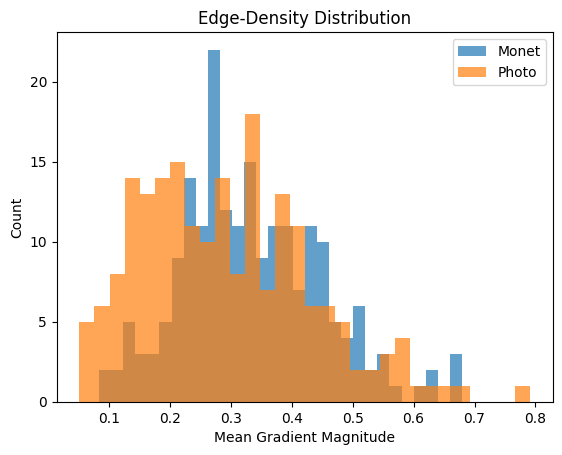

In [25]:
plt.hist(monet_edges, bins=30, alpha=0.7, label="Monet")
plt.hist(photo_edges, bins=30, alpha=0.7, label="Photo")
plt.title("Edge-Density Distribution")
plt.xlabel("Mean Gradient Magnitude")
plt.ylabel("Count")
plt.legend()
plt.show()

### Average Image

In [26]:
def show_average_image(file_list, num=200, title="Average"):
    sample = random.sample(file_list, min(len(file_list), num))
    acc = np.zeros((256,256,3), dtype=np.float32)
    for fp in sample:
        img = np.array(Image.open(fp).resize((256,256))).astype(np.float32)/255.0
        acc += img
    avg = acc / len(sample)
    plt.figure(figsize=(4,4))
    plt.imshow(avg)
    plt.title(title)
    plt.axis("off")
    plt.show()

### Monet Paintings

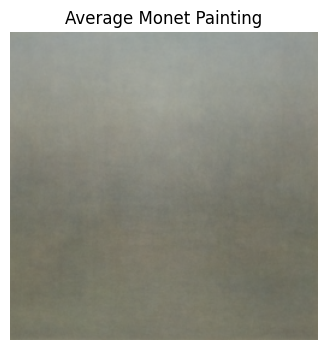

In [27]:
show_average_image(monet_files, title="Average Monet Painting")

### Photographs

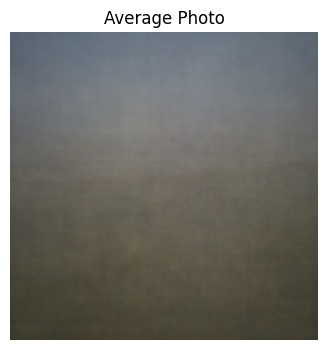

In [28]:
show_average_image(photo_files, title="Average Photo")


# Generator

## Conv Block

In [29]:
def conv_block(x, filters, kernel_size=4, strides=2, activation=True):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding="same",
                      kernel_initializer="he_normal", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    if activation:
        x = layers.LeakyReLU(0.2)(x)
    return x

## Deconv Block

In [30]:
def deconv_block(x, filters, kernel_size=4, strides=2, dropout=False):
    x = layers.Conv2DTranspose(filters, kernel_size, strides=strides,
                               padding="same", kernel_initializer="he_normal", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    if dropout:
        x = layers.Dropout(0.5)(x)
    x = layers.ReLU()(x)
    return x

## Build Generator

In [31]:
def build_unet_generator(img_size=256, out_channels=3):
    inputs = layers.Input(shape=[img_size, img_size, 3])

    # --- Encoder ---
    skips = []
    x = inputs
    for f in [64, 128, 256, 512]:
        x = conv_block(x, f)
        skips.append(x)

    # Bottleneck (down to 8×8)
    x = conv_block(x, 512)

    # --- Decoder ---
    # Upsample filters, mirror of encoder
    up_filters = [512, 256, 128, 64]

    for f, skip in zip(up_filters, reversed(skips)):
        x = deconv_block(x, f, dropout=(f==512))
        x = layers.Concatenate()([x, skip])

    # Final upsample back to original 256×256
    x = layers.Conv2DTranspose(out_channels, 4, strides=2, padding="same",
                               activation="tanh", kernel_initializer="he_normal")(x)

    return Model(inputs=inputs, outputs=x, name="UNetGenerator")

## Instantiate Generators

In [32]:
generator_G = build_unet_generator() 
generator_F = build_unet_generator()
print('Generator G Shape: ', generator_G.output_shape)
print('Generator F Shape: ', generator_F.output_shape)

Generator G Shape:  (None, 256, 256, 3)
Generator F Shape:  (None, 256, 256, 3)


## Generator G Summary
Photo to Monet

In [33]:
generator_G.summary()

Model: "UNetGenerator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      3,072 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │    131,072 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │    524,288 │ leaky_re_lu_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │  2,097,152 │ leaky_re_lu_2[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 512) │  4,194,304 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  4,194,304 │ leaky_re_lu_4[0]… │
│ (Conv2DTranspose)   │ 512)              │            │                 

 Total params: 16,665,091 (63.57 MB)

 Trainable params: 16,660,227 (63.55 MB)

 Non-trainable params: 4,864 (19.00 KB)

## Generator F Summary
Monet to Photos

In [34]:
generator_F.summary()

Model: "UNetGenerator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │      3,072 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    131,072 │ leaky_re_lu_5[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    524,288 │ leaky_re_lu_6[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  2,097,152 │ leaky_re_lu_7[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 512) │  4,194,304 │ leaky_re_lu_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_9       │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_5  │ (None, 16, 16,    │  4,194,304 │ leaky_re_lu_9[0]… │
│ (Conv2DTranspose)   │ 512)              │            │                 

 Total params: 16,665,091 (63.57 MB)

 Trainable params: 16,660,227 (63.55 MB)

 Non-trainable params: 4,864 (19.00 KB)

# Discriminator

## Build Discriminator

In [35]:
def build_discriminator(input_size=256):
    """PatchGAN discriminator: outputs a 30×30 patch map of “real vs fake” scores."""
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=(input_size, input_size, 3))

    # Downsample 1: 256→128
    x = layers.Conv2D(64, 4, strides=2, padding='same',
                      kernel_initializer=initializer)(inp)
    x = layers.LeakyReLU(0.2)(x)

    # Downsample 2: 128→64
    x = layers.Conv2D(128, 4, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    # Downsample 3: 64→32
    x = layers.Conv2D(256, 4, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    # Downsample 4: 32→31 (no stride)
    x = layers.Conv2D(512, 4, strides=1, padding='same',
                      kernel_initializer=initializer, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    # Final 30×30 patch output
    x = layers.Conv2D(1, 4, strides=1, padding='same',
                      kernel_initializer=initializer)(x)

    return Model(inputs=inp, outputs=x, name="PatchGAN_Discriminator")

## Instantiate Discriminator

In [36]:
discriminator_X = build_discriminator()  # for Photo→Monet
discriminator_Y = build_discriminator()  # for Monet→Photo
print("Discriminator X output shape:", discriminator_X.output_shape)
print("Discriminator Y output shape:", discriminator_Y.output_shape)

Discriminator X output shape: (None, 32, 32, 1)
Discriminator Y output shape: (None, 32, 32, 1)


## Discriminator X Summary
Photo to Monet

In [37]:
discriminator_X.summary()

Model: "PatchGAN_Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 256)    │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,767,425 (10.56 MB)

 Trainable params: 2,765,633 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

## Discriminator Y Summary
Monet to Photo

In [38]:
discriminator_X.summary()

Model: "PatchGAN_Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 256)    │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,767,425 (10.56 MB)

 Trainable params: 2,765,633 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

# Loss Function

## Adversarial Loss

In [39]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Generator

In [40]:
def generator_adversarial_loss(fake_logits):
    # want D(fake) → 1
    return bce(tf.ones_like(fake_logits), fake_logits)

### Discriminator

In [41]:
def discriminator_adversarial_loss(real_logits, fake_logits):
    # real → 1, fake → 0
    real_loss = bce(tf.ones_like(real_logits), real_logits)
    fake_loss = bce(tf.zeros_like(fake_logits), fake_logits)
    return (real_loss + fake_loss) * 0.5

## Cycle Consistency Loss

In [42]:
def cycle_consistency_loss(real_image, cycled_image):
    # both real_image and cycled_image are float16
    return LAMBDA * tf.reduce_mean(tf.abs(real_image - cycled_image))

## Identity Loss

In [43]:
def identity_loss(real_image, same_image):
    return LAMBDA * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))

# Image Snapshot Class

In [44]:
class ImageSnapshot(tf.keras.callbacks.Callback):
    def __init__(self, photo_ds, save_dir, num=3):
        super().__init__()
        self.photo_iter = iter(photo_ds)
        self.save_dir = save_dir
        self.num = num

    def on_epoch_end(self, epoch, logs=None):
        # grab num photos
        batch = [ next(self.photo_iter) for _ in range(self.num) ]
        photos = tf.concat(batch, axis=0)              # (num,256,256,3)
        gens   = self.model.G(photos, training=False)
        photos = (photos + 1.0) / 2.0
        gens   = (gens   + 1.0) / 2.0

        for i in range(self.num):
            fig, axes = plt.subplots(1,2,figsize=(6,3))
            axes[0].imshow(photos[i].numpy());  axes[0].set_title("Photo"); axes[0].axis("off")
            axes[1].imshow(gens[i].numpy());    axes[1].set_title("Monet"); axes[1].axis("off")
            fig.tight_layout()

            path = os.path.join(self.save_dir, f"epoch{epoch+1:03d}_sample{i+1}.png")
            fig.savefig(path)
            plt.close(fig)
        print(f"\n[Snapshot] Saved {self.num} samples for epoch {epoch+1}")

# Cycle GAN Class

In [45]:
class CycleGAN(tf.keras.Model):
    def __init__(self, G, F, D_X, D_Y):
        super().__init__()
        self.G = G        # Photo → Monet
        self.F = F        # Monet → Photo
        self.D_X = D_X    # Monet discriminator
        self.D_Y = D_Y    # Photo discriminator

    def compile(self,
                G_optimizer,
                F_optimizer,
                D_X_optimizer,
                D_Y_optimizer,
                gen_loss_fn,
                disc_loss_fn,
                cycle_loss_fn,
                identity_loss_fn):
        super().compile()
        self.G_opt = G_optimizer
        self.F_opt = F_optimizer
        self.D_X_opt = D_X_optimizer
        self.D_Y_opt = D_Y_optimizer
        self.gen_loss = gen_loss_fn
        self.disc_loss = disc_loss_fn
        self.cycle_loss = cycle_loss_fn
        self.id_loss = identity_loss_fn

    def build(self, input_shape):
        # input_shape is a tuple of shapes for (photo_batch, monet_batch)
        photo_shape, monet_shape = input_shape
        self.G.build(photo_shape)
        self.F.build(monet_shape)
        self.D_X.build(monet_shape)
        self.D_Y.build(photo_shape)
        super().build(input_shape)
        
    @tf.function
    def train_step(self, batch):
        real_x, real_y = batch  # x=photos, y=Monets
        with tf.GradientTape(persistent=True) as tape:
            # 1) Generators
            fake_y = self.G(real_x, training=True)
            fake_x = self.F(real_y, training=True)

            # 2) Cycle
            cycled_x = self.F(fake_y, training=True)
            cycled_y = self.G(fake_x, training=True)

            # 3) Identity
            same_x = self.F(real_x, training=True)
            same_y = self.G(real_y, training=True)

            # 4) Discriminators
            D_real_x = self.D_X(real_y, training=True)
            D_fake_x = self.D_X(fake_y, training=True)
            D_real_y = self.D_Y(real_x, training=True)
            D_fake_y = self.D_Y(fake_x, training=True)

            # 5) Compute losses
            G_adv_loss = self.gen_loss(D_fake_x)
            F_adv_loss = self.gen_loss(D_fake_y)

            cycle_loss = (
                self.cycle_loss(real_x, cycled_x) +
                self.cycle_loss(real_y, cycled_y)
            )
            identity_loss = (
                self.id_loss(real_x, same_x) +
                self.id_loss(real_y, same_y)
            )
            total_G_loss = G_adv_loss + cycle_loss + identity_loss
            total_F_loss = F_adv_loss + cycle_loss + identity_loss

            D_X_loss = self.disc_loss(D_real_x, D_fake_x)
            D_Y_loss = self.disc_loss(D_real_y, D_fake_y)

        # 6) Compute & apply gradients
        grads_G = tape.gradient(total_G_loss, self.G.trainable_variables)
        grads_F = tape.gradient(total_F_loss, self.F.trainable_variables)
        grads_DX = tape.gradient(D_X_loss, self.D_X.trainable_variables)
        grads_DY = tape.gradient(D_Y_loss, self.D_Y.trainable_variables)

        self.G_opt.apply_gradients(zip(grads_G, self.G.trainable_variables))
        self.F_opt.apply_gradients(zip(grads_F, self.F.trainable_variables))
        self.D_X_opt.apply_gradients(zip(grads_DX, self.D_X.trainable_variables))
        self.D_Y_opt.apply_gradients(zip(grads_DY, self.D_Y.trainable_variables))

        return {
            "G_loss": total_G_loss,
            "F_loss": total_F_loss,
            "D_X_loss": D_X_loss,
            "D_Y_loss": D_Y_loss,
        }

## Instantiate

In [46]:
cyclegan = CycleGAN(generator_G, generator_F, discriminator_X, discriminator_Y)

## Build

In [47]:
cyclegan.build([(None,256,256,3), (None,256,256,3)])

## Callbacks

### Checkpoint

In [48]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(CKPT_DIR, "cyclegan_epoch_{epoch:02d}.weights.h5"),
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)

### Snapshot

In [49]:
image_cb = ImageSnapshot(photo_ds, IMG_SNAPSHOT_DIR, num=3)

## Compile

In [50]:
cyclegan.compile(
    G_optimizer   = tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    F_optimizer   = tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    D_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    D_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_loss_fn     = generator_adversarial_loss,
    disc_loss_fn    = discriminator_adversarial_loss,
    cycle_loss_fn   = cycle_consistency_loss,
    identity_loss_fn= identity_loss
)

# Train Model

## Zip Dataset

In [51]:
train_ds = tf.data.Dataset.zip((photo_ds, monet_ds))
steps_per_epoch = min(len(photo_files), len(monet_files)) // BATCH_SIZE

## Load From Checkpoint

In [52]:
weight_files = sorted(glob(os.path.join(CKPT_DIR, "cyclegan_epoch_*.weights.h5")))
initial_epoch = 0
if weight_files:
    latest = weight_files[-1]
    m = re.search(r"cyclegan_epoch_(\d+)\.weights\.h5$", latest)
    if m:
        initial_epoch = int(m.group(1))
        # 3) Load it
        print(f"🕹 Loading weights from '{latest}' (epoch {initial_epoch})")
        cyclegan.load_weights(latest)
        print('Found weight file: ', latest)

## Initiate Training

In [53]:
if initial_epoch < EPOCHS:
    print(f"Starting training from epoch {initial_epoch+1} to {EPOCHS}.")
    history = cyclegan.fit(
        tf.data.Dataset.zip((photo_ds, monet_ds)),
        epochs=EPOCHS,
        initial_epoch=initial_epoch,
        steps_per_epoch=steps_per_epoch,
        callbacks=[TqdmCallback(verbose=1), checkpoint_cb, image_cb]
    )
else:
    print(f"Already trained through epoch {EPOCHS}. Skipping fit().")

Starting training from epoch 1 to 10.


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - D_X_loss: 0.4758 - D_Y_loss: 0.4664 - F_loss: 17.1498 - G_loss: 17.1386
Epoch 1: saving model to /kaggle/working/output/checkpoints/cyclegan_epoch_01.weights.h5

[Snapshot] Saved 3 samples for epoch 1
300/300 ━━━━━━━━━━━━━━━━━━━━ 1095s 3s/step - D_X_loss: 0.4744 - D_Y_loss: 0.4661 - F_loss: 17.1502 - G_loss: 17.1403
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - D_X_loss: 0.1236 - D_Y_loss: 0.1726 - F_loss: 14.9186 - G_loss: 15.6148
Epoch 2: saving model to /kaggle/working/output/checkpoints/cyclegan_epoch_02.weights.h5

[Snapshot] Saved 3 samples for epoch 2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1039s 3s/step - D_X_loss: 0.1232 - D_Y_loss: 0.1722 - F_loss: 14.9048 - G_loss: 15.6037
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - D_X_loss: 0.0249 - D_Y_loss: 0.1581 - F_loss: 14.3302 - G_loss: 15.6293
Epoch 3: saving model to /kaggle/working/output/checkpoints/cyclegan_epoch_03.weights.h5

[Snapshot] Saved 3 samples for epoch 3
300/

# Preview Results

## Preview Function

In [54]:
def show_monet_previews(generator, photo_ds, num=5):
    it = iter(photo_ds)
    plt.figure(figsize=(8, 4*num))
    for i in range(num):
        photo_batch = next(it)              # (1,256,256,3)
        photo_img   = (photo_batch[0]+1)/2  # back to [0,1]
        monet_img   = (generator(photo_batch)[0]+1)/2

        # plot
        ax = plt.subplot(num, 2, 2*i+1)
        plt.imshow(photo_img.numpy())
        plt.title("Real Photo"); plt.axis("off")

        ax = plt.subplot(num, 2, 2*i+2)
        plt.imshow(monet_img.numpy())
        plt.title("Generated Monet"); plt.axis("off")
    plt.tight_layout()
    plt.show()

## Painting Preview

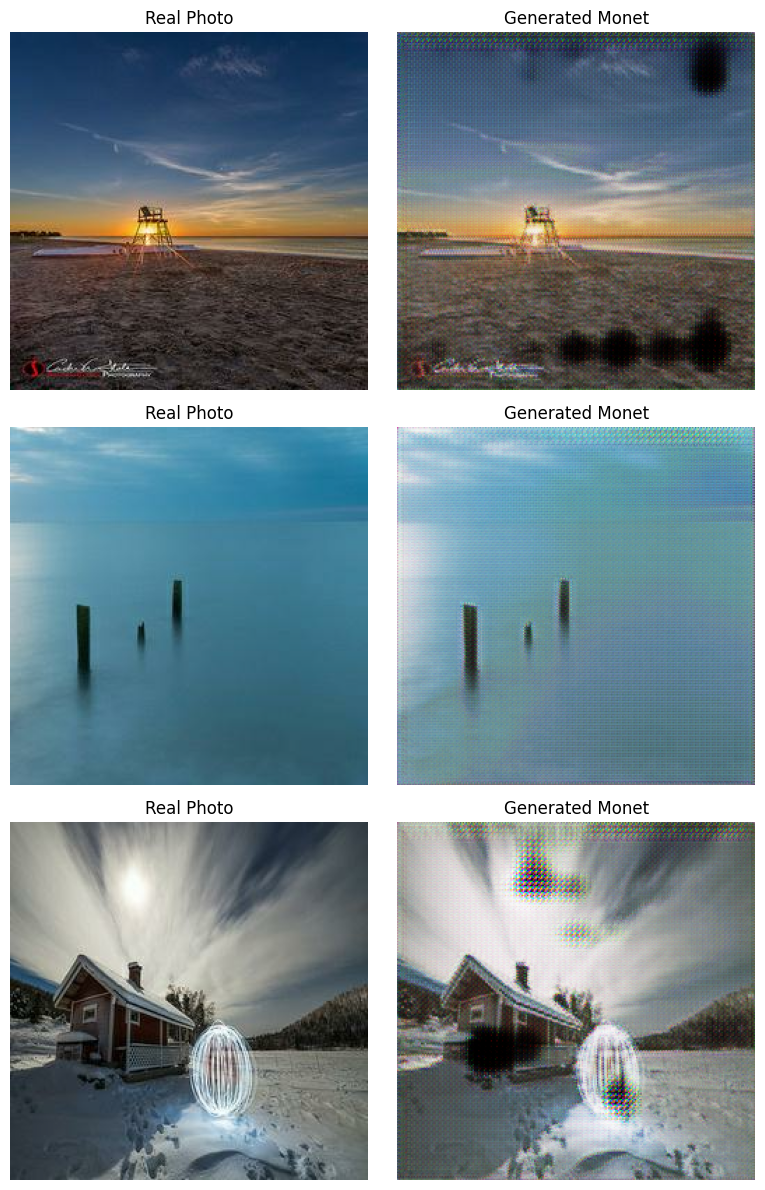

In [55]:
show_monet_previews(cyclegan.G, photo_ds, num=3)

# Generate Images

In [56]:
def denormalize_to_uint8(img):
    img = (img + 1.0) / 2.0        # to [0,1]
    img = tf.clip_by_value(img, 0, 1)
    return tf.image.convert_image_dtype(img, tf.uint8, saturate=True)

## Generator Function

In [57]:
def generate_images(generator, photo_paths, output_dir, start_idx=0, max_images=500):
    count = 0
    for i, p in enumerate(photo_paths):
        if count >= max_images: 
            break
        # load + preprocess
        img = tf.io.decode_jpeg(tf.io.read_file(p), channels=3)
        img = tf.image.resize(img, [256,256])
        img = (tf.cast(img,tf.float32)/127.5)-1.0
        # infer
        out = generator(tf.expand_dims(img,0), training=False)[0]
        out = denormalize_to_uint8(out).numpy()
        # save
        Image.fromarray(out).save(os.path.join(
            output_dir, f"{start_idx+count:04d}.jpg"
        ))
        count += 1
    return count

## Generate in Batches

In [58]:
for start in range(0, TOTAL_IMGS, GEN_BATCH):
    end = min(start + GEN_BATCH, TOTAL_IMGS)
    batch_paths = photo_files[start:end]

    n = generate_images(
        generator=cyclegan.G,
        photo_paths=batch_paths,
        output_dir=IMG_DIR,
        start_idx=start,
        max_images=GEN_BATCH
    )
    print(f" generated {n} images [{start:04d}–{start+n-1:04d}]")

 generated 500 images [0000–0499]
 generated 500 images [0500–0999]
 generated 500 images [1000–1499]
 generated 500 images [1500–1999]
 generated 500 images [2000–2499]
 generated 500 images [2500–2999]
 generated 500 images [3000–3499]
 generated 500 images [3500–3999]
 generated 500 images [4000–4499]
 generated 500 images [4500–4999]
 generated 500 images [5000–5499]
 generated 500 images [5500–5999]
 generated 500 images [6000–6499]
 generated 500 images [6500–6999]


## Display Generated Images

In [59]:
def show_random_generated_images(generated_dir, num_images=5, cols=5, img_size=(256,256)):
    """
    Pick `num_images` at random from `generated_dir` and display them in a row.
    """
    # find all jpgs
    all_files = [f for f in os.listdir(generated_dir) if f.endswith('.jpg')]
    # sample
    chosen = random.sample(all_files, min(num_images, len(all_files)))
    
    plt.figure(figsize=(cols*3, 3))
    for i, fname in enumerate(chosen):
        img = Image.open(os.path.join(generated_dir, fname)).resize(img_size)
        ax = plt.subplot(1, cols, i+1)
        plt.imshow(img)
        plt.title(fname)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


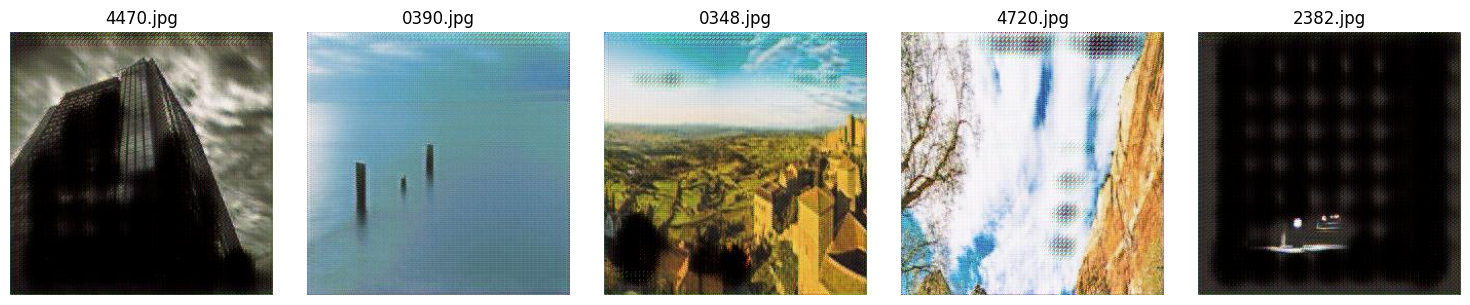

In [60]:
show_random_generated_images(IMG_DIR, num_images=5)

# Zip Images For Submission

In [61]:
with zipfile.ZipFile(SUBMISSION_ZIP, 'w', zipfile.ZIP_DEFLATED) as zf:
    for fname in sorted(os.listdir(IMG_DIR)):
        if fname.endswith('.jpg'):
            zf.write(os.path.join(IMG_DIR, fname), arcname=fname)

print(f"Submission ready: {SUBMISSION_ZIP}")

Submission ready: /kaggle/working/images.zip


# Github

This code will be provided at the following repository: https://github.com/thor625/Monet-Painting-Generation-CycleGAN

# Conclusion

## Summary


- **Data pipelines** for both TFRecord and JPG inputs, with resizing, normalization (to `[-1,1]`), caching and prefetching for high throughput.  
- **CycleGAN architecture** (ResNet-style generators + PatchGAN discriminators) trained adversarially plus cycle-consistency/identity losses to translate photos ↔ Monet paintings.  
- **Training scaffolding** with `tf.keras.Model` subclassing, custom `train_step`, progress bars, model checkpoints and sample snapshots each epoch.  
- **Inference utilities** to batch-convert any folder of photos into Monet-style outputs, save as JPEGs (and zip for easy download), or quick in-notebook previews.


## Next Steps

1. **Quality Improvements**  
   - **Hyperparameter tuning**: experimenting with learning rate and epochs will likely result in better results.  
   - **Architectural tweaks**: add more residual blocks; try deeper or wider U-Nets; swap instance-norm for layer-norm.  
   - **Perceptual losses**: incorporate VGG-based feature losses for sharper style transfer.  

2. **Training Enhancements**  
   - **Mixed precision**: enable float16 compute on GPUs to speed up training (watch for type-mismatch bugs).  
   - **Distributed training**: leverage multiple GPUs or TPU for faster epochs.  
   - **Learning-rate schedulers**: apply warm-up, cosine decay, or cyclical LR to stabilize convergence.  

3. **Data Augmentation & Expansion**  
   - **Augmentations**: color jitter, random crops, cutout to improve robustness.  
   - **Additional styles**: incorporate paintings from other artists (Van Gogh, Picasso) to train multi-style translator.  

4. **Evaluation & Metrics**  
   - **FID / IS scores**: compute Fréchet Inception Distance or Inception Score between real Monet and generated outputs.  
   - **User studies**: collect human ratings on “aesthetic appeal” or “style fidelity.”